In [6]:
!pip install numpy
!pip install matplotlib
!pip install graphviz
!pip install torch

You should consider upgrading via the '/Users/nikasakandelidze/deeplearning/deeplearning/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/nikasakandelidze/deeplearning/deeplearning/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/nikasakandelidze/deeplearning/deeplearning/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/nikasakandelidze/deeplearning/deeplearning/bin/python -m pip install --upgrade pip' command.


In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def f(x):
    return x**2 + 2*x

In [9]:
xs = np.arange(-10, 10, 0.5)
ys = f(xs)

120

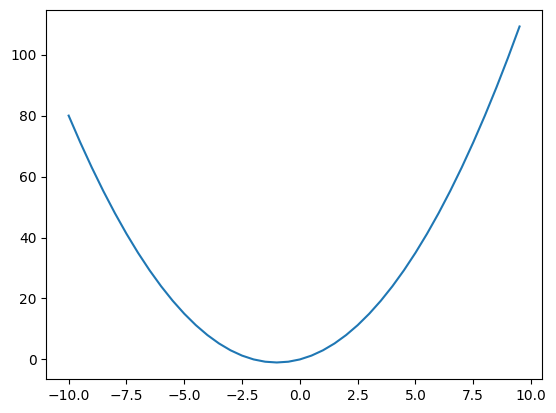

In [10]:
plt.plot(xs, ys)
f(10)

In [11]:
h = 0.000000000001
x = 3.0
y = f(x)
(f(x + h) - f(x))/h

8.000711204658728

In [118]:
class Value:
    def __init__(self, value, _children=(), _op="", label=""):
        self.data = value
        self.grad = 0.0
        self._backward  = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        val = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1 * val.grad
            other.grad += 1 * val.grad
        val._backward = _backward
        return val
    
    def __rmul__(self, other):
        return self * other
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        val = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += val.grad * other.data
            other.grad += val.grad * self.data
        val._backward = _backward
        return val
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __sub__(self, other):
        return self + -1*other
    
    def __pow__(self, k):
        val = Value(self.data**k, (self,), f"**{k}")
        def _backward():
            self.grad += val.grad * k * self.data**(k-1)
        val._backward = _backward
        return val
    
    def exp(self):
        x = self.data
        val = Value(math.exp(x), (self,), "exp")
        def _backward():
            self.grad += val.grad * val.data
        val._backward = _backward
        return val
    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)        
        val = Value(t, (self,), "tanh")
        def _backward():
            self.grad += (1 - t**2) * val.grad
        val._backward = _backward
        return val    

In [23]:
a = Value(4)
b = Value(2)
a/b


Value(data=2.0)

In [32]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

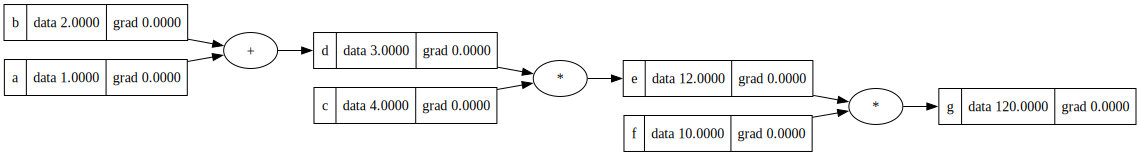

In [14]:
a = Value(1, label='a')
b = Value(2, label='b')
c = Value(4, label='c')
d = a + b; d.label = 'd'
e = d * c; e.label = 'e'
f = Value(10, label='f')
g = e * f; g.label = 'g'
draw_dot(g)


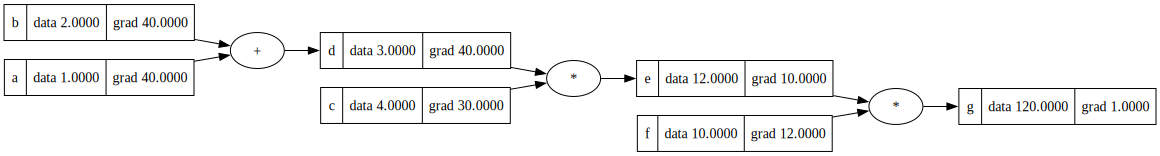

In [15]:
h = 0.0001
def manual_grad_calc():
    
    def getOutput(increased=False, varName=None):
        if increased and not varName:
            raise Exception('increased and varName must be present both or none')
        a = Value(1 + h if increased and varName == 'a' else 1, label='a')
        b = Value(2 + h if increased and varName == 'b' else 2, label='b')
        c = Value(4 + h if increased and varName == 'c' else 4, label='c')
        d = a + b
        if increased and varName == 'd':
            d.data += h
        d.label = 'd'
        e = (d * c)
        if increased and varName == 'e':
            e.data += h
        e.label = 'e'
        f = Value(10 + h if increased and varName == 'f' else 10, label='f')
        g = e * f
        if increased and varName == 'g':
            g.data += h
        g.label = 'g'
        

        return g
    
    result = {}
    
    for var in ['e', 'f', 'g']:
        raised = getOutput(True, var)
        original = getOutput()
        grad = (raised.data - original.data) / h
        result[var] = grad
    return result

grads = manual_grad_calc()


# Gradients for these variables don't need to use chain rule from calculus
e.grad = grads['e']
f.grad = grads['f']
g.grad = grads['g']

# dg/dc  needs to use chain rule = dg/de * de/dc = 10 * 3 = 30
c.grad = 30

# dg/dd  needs to use chain rule = dg/de * de/dd = 10 * 3 = 30
d.grad = 40

# dg/db needs to use chain rule = dg/de * de/dd * dd/db = 10 * 4 * 1 = 400
b.grad = 40

# da/db needs to use chain rule = dg/de * de/dd * dd/da = 10 * 4 * 1 = 40
a.grad = 40

# results for a and b being same as for d is intuitive since plus sign simply distributed the gradient of the parent

draw_dot(g)

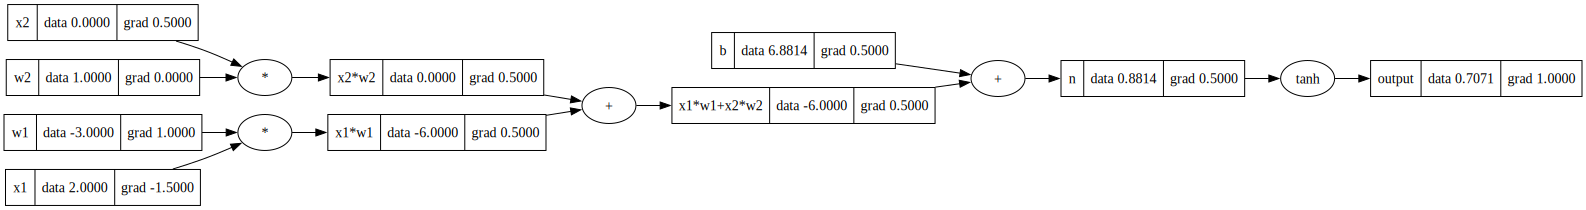

In [38]:
# Basic Single Neuron

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weight
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.88137358, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1' 
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
output = n.tanh(); output.label = 'output'

output.grad = 1.0
output.backward()

draw_dot(output)



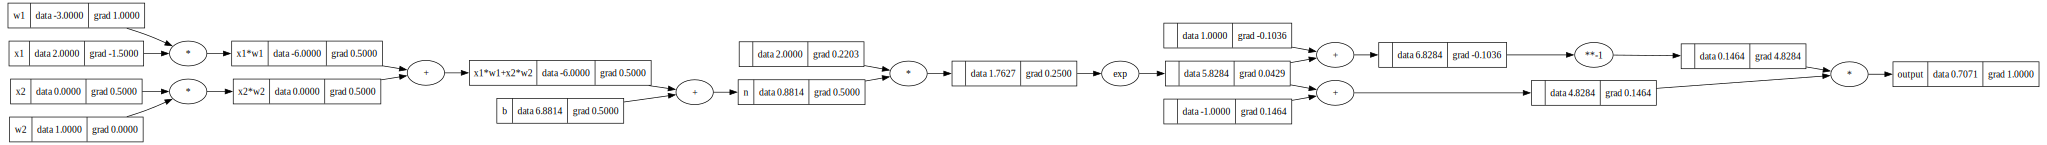

In [39]:
# Basic Single Neuron without tanh

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weight
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.88137358, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
e = (2*n).exp()
output = (e -1)/(e+1)

output.label = 'output'

output.grad = 1
output.backward()

draw_dot(output)

In [40]:
# Torch example

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad=True
b = torch.Tensor([6.88137358]).double(); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

0.7071066904050358
-1.5000003851533106
0.5000001283844369
1.0000002567688737
0.0


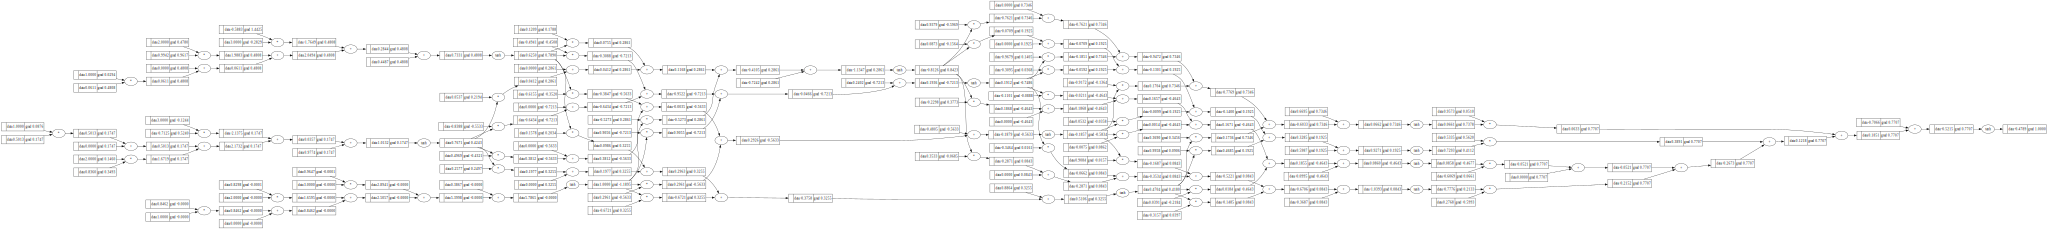

In [152]:
import random

class Neuron():
    def __init__(self, inputCount):
        self.inputCount = inputCount
        self.w = [Value(random.uniform(-1, 1)) for _ in range(inputCount)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, input):
        if len(input) != len(self.w):
            raise Exception('incorrect dimensions of input for neuron')
        res = Value(0)
        for w,x in  zip(input, self.w):
            res += w*x
        linear = res +self.b
        nonLinear = linear.tanh()
        return nonLinear
    
    def parameters(self):
        return self.w + [self.b]
    
# Specifically Multi Layer Perceptron where each output from one neuron is connected to every neuron in the next layer
class Layer():
    def __init__(self, neuronsCount, neuronInputsCount):
        self.neuronInputsCount = neuronInputsCount
        self.neuronsCount = neuronsCount
        self.neurons = [Neuron(neuronInputsCount) for _ in range(neuronsCount)]
        
    def __call__(self, input):
        if len(input) != self.neuronInputsCount:
            raise Exception('incorrect dimensions of input for layer')
        result = []
        for neuron in self.neurons:
            result.append(neuron(input))
        return result[0] if len(result) == 1 else result
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params += neuron.parameters()
        return params
            
class MultiLayerPerceptron():
    def __init__(self, layersCount, neuronsCountPerLayerList, inputSize):
        self.layers = []
        for i in range(layersCount):
            neuronsCount = neuronsCountPerLayerList[i]
            self.layers.append(Layer(neuronsCount, inputSize))
            inputSize = neuronsCount
            
    def __call__(self, input):
        if len(input) != self.layers[0].neuronInputsCount:
            raise Exception('incorrect dimensions of input for perceptron')
        for layer in self.layers:
            input = layer(input)
        return input
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters()
        return params
        
    
perceptron = MultiLayerPerceptron(4, [3, 4, 4, 1], 3)
output = perceptron([1,2,3])
output.backward()
draw_dot(output)

In [146]:
# simple loss function
perceptron = MultiLayerPerceptron(4, [3, 4, 4, 1], 3)

inputs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

outputs = [1.0, -1.0, -1.0, 1.0]

results = [perceptron(x) for x in inputs]

def lossFunction(hypotheses, real):
    result = Value(0)
    for x, y in zip(hypotheses, real):
        result += (x-y)**2
    return result


loss = lossFunction(results, outputs)
print('loss=',loss.data)

sampleWeightBeforeBackward = sampleGradientOfSampleWeight = perceptron.layers[0].neurons[0].w[0]
print(sampleWeightBeforeBackward.data, sampleWeightBeforeBackward.grad)

loss.backward()

print(sampleWeightBeforeBackward.data, sampleWeightBeforeBackward.grad)

parameters = perceptron.parameters()
print(parameters)

draw_dot(loss)

loss= 4.117470700304152
-0.2986419965131706 0.0
-0.2986419965131706 1.2178753757455545
[Value(data=-0.2986419965131706, grad=1.2178753757455545), Value(data=0.11940546341127822, grad=1.694108490039362), Value(data=-0.6000940085926079, grad=-0.954657818022555), Value(data=-0.22085000485021933, grad=0.42644953803018437), Value(data=0.3991819590936636, grad=-1.3740794184187415), Value(data=-0.7334329479882145, grad=-2.042367821199439), Value(data=-0.7571263239966639, grad=1.135492929300254), Value(data=0.0284855384743683, grad=-0.542461499326425), Value(data=0.9081900825360552, grad=0.11677659685734611), Value(data=0.8063303041736583, grad=0.2736785918519219), Value(data=-0.8365087836069975, grad=0.26581387884791835), Value(data=0.5393364114294332, grad=0.2623722376935655), Value(data=0.05661942510892026, grad=0.3523700495542938), Value(data=-0.9910426559930852, grad=0.18775176771248597), Value(data=-0.49790263400125956, grad=0.027885751120724736), Value(data=-0.8510286942557719, grad=-0.

In [150]:
# train neural network
for i in range(100):
    for p in parameters:
        p.data += -1 * 0.01 * p.grad
    results = [perceptron(x) for x in inputs]
    loss = lossFunction(results, outputs)
    loss.backward()
    if i % 10 == 0:
        print(f'loss={loss.data}')

print('predictions after training', list(map(lambda x: x.data, [perceptron(x) for x in inputs])))
print('outputs', outputs)

loss=4.557031737855188e-12
loss=1.008465111475776e-12
loss=1.9244753556606445e-13
loss=3.121734250168132e-14
loss=4.2497815074087126e-15
loss=4.806118118123086e-16
loss=4.485777456437704e-17
loss=3.449301641303225e-18
loss=2.1939740760343796e-19
loss=1.1666760654692963e-20
predictions after training [1.0, -0.9999999999809561, -0.9999999999809875, 1.0]
outputs [1.0, -1.0, -1.0, 1.0]
